In [2]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-3
input_dim = 28 * 28 * 1
hidden_dim = 512
latent_dim = 256
batch_size = 100
epochs = 50

print(device)

cuda


In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        # self.encoder = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(input_dim, hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.ReLU(),
        # )

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2),
        )

        self.mu = nn.Linear(latent_dim, 2) # Mean of latent distribution
        self.logvar = nn.Linear(latent_dim, 2) # Log variance of latent distribution

        # Decoder
        # self.decoder = nn.Sequential(
        #     nn.Linear(latent_dim, hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim, input_dim),
        #     nn.Sigmoid() # Output pixel values between 0 and 1
        # )

        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.mu(x), self.logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [5]:
def vae_loss(x, x_recon, mu, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

In [8]:
%%time
transforms = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_dataset = torchvision.datasets.MNIST(
    root='dataset/', train=True, transform=transforms, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='dataset/', train=False, transform=transforms, download=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 58.3kB/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.45MB/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

CPU times: user 543 ms, sys: 228 ms, total: 771 ms
Wall time: 20.6 s


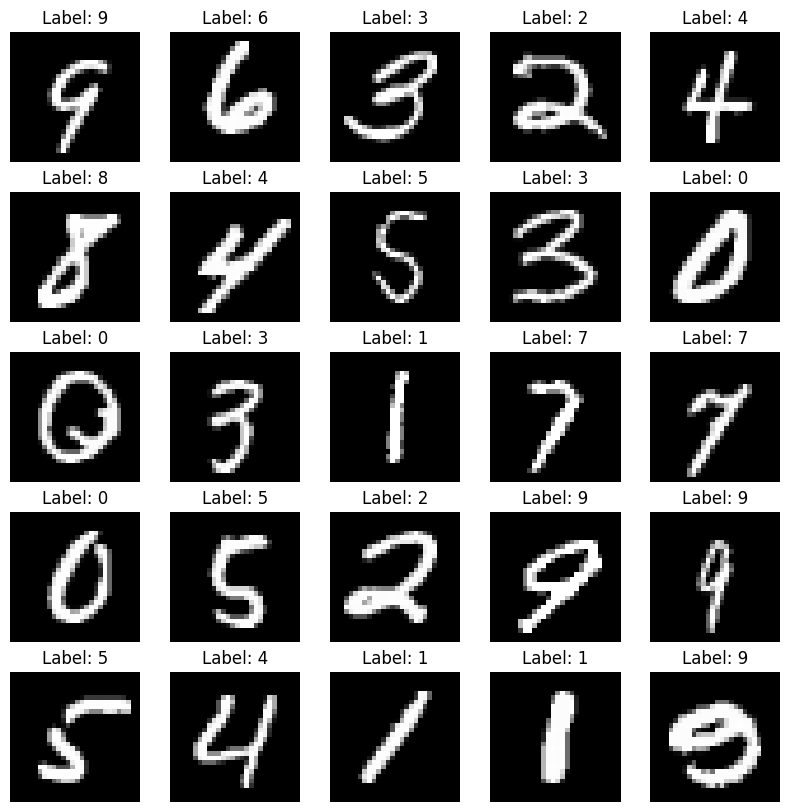

In [26]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

num_samples = 25
sample_imgs, sample_labels = images[:num_samples], labels[:num_samples]

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.3)

for ax, img, label in zip(grid, sample_imgs, sample_labels):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label.item()}")
    ax.axis('off')

plt.show()

In [27]:
model = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [28]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, input_dim).to(device)
        x_recon, mu, log_var = model(x)
        loss = vae_loss(x, x_recon, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}')

Epoch 1/50, Train Loss: 177.2968
Epoch 2/50, Train Loss: 159.6845
Epoch 3/50, Train Loss: 155.8779
Epoch 4/50, Train Loss: 153.5288
Epoch 5/50, Train Loss: 151.8958
Epoch 6/50, Train Loss: 150.5833
Epoch 7/50, Train Loss: 149.4290
Epoch 8/50, Train Loss: 148.5238
Epoch 9/50, Train Loss: 147.9284
Epoch 10/50, Train Loss: 147.2044
Epoch 11/50, Train Loss: 146.6733
Epoch 12/50, Train Loss: 146.1645
Epoch 13/50, Train Loss: 145.7321
Epoch 14/50, Train Loss: 145.4119
Epoch 15/50, Train Loss: 144.9699
Epoch 16/50, Train Loss: 144.7024
Epoch 17/50, Train Loss: 144.2991
Epoch 18/50, Train Loss: 144.1392
Epoch 19/50, Train Loss: 143.8410
Epoch 20/50, Train Loss: 143.6465
Epoch 21/50, Train Loss: 143.3569
Epoch 22/50, Train Loss: 143.2323
Epoch 23/50, Train Loss: 142.9648
Epoch 24/50, Train Loss: 142.6766
Epoch 25/50, Train Loss: 142.6480
Epoch 26/50, Train Loss: 142.3375
Epoch 27/50, Train Loss: 142.2100
Epoch 28/50, Train Loss: 142.0035
Epoch 29/50, Train Loss: 141.9079
Epoch 30/50, Train Loss

In [33]:
def generate_digit(mu, var):
    z_sample = torch.tensor([[mu, var]], dtype=torch.float32).to(device)
    x_decoded = model.decode(z_sample).view(28, 28)
    digit = x_decoded.detach().cpu().numpy()
    plt.imshow(digit, cmap='gray')
    plt.title(f'[{mu}, {var}]')
    plt.axis('off')
    plt.show()

def plot_latent_space(model, scale=1.0, n=25, digit_size=28):
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded.view(digit_size, digit_size).detach().cpu().numpy()
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(15, 15))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.title('VAE Latent Space Visualization')
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z[0]")
    plt.ylabel("var, z[1]")
    plt.imshow(figure, cmap='gray')
    plt.show()

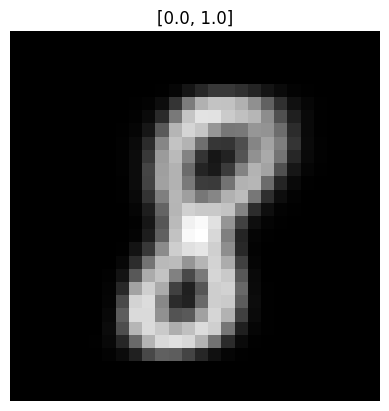

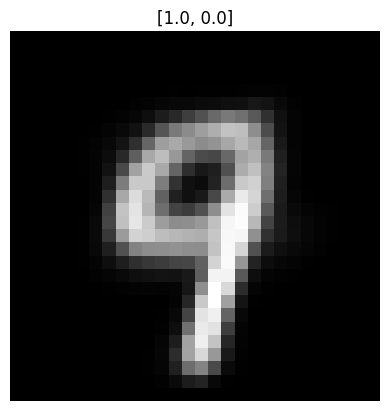

(None, None)

In [31]:
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

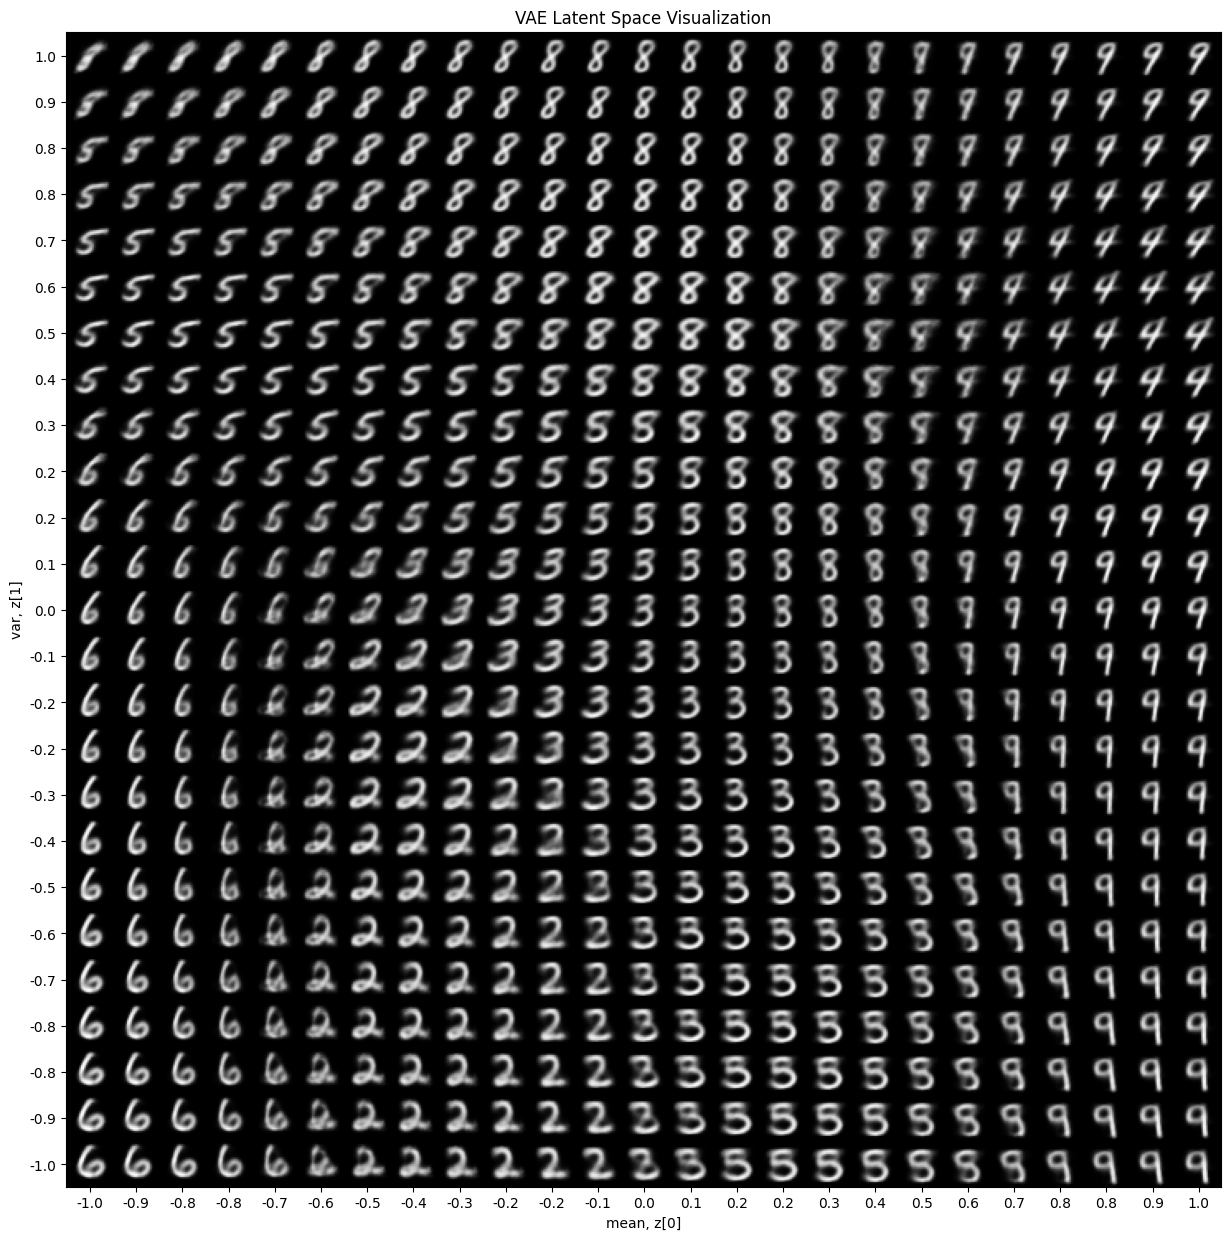

In [34]:
plot_latent_space(model)

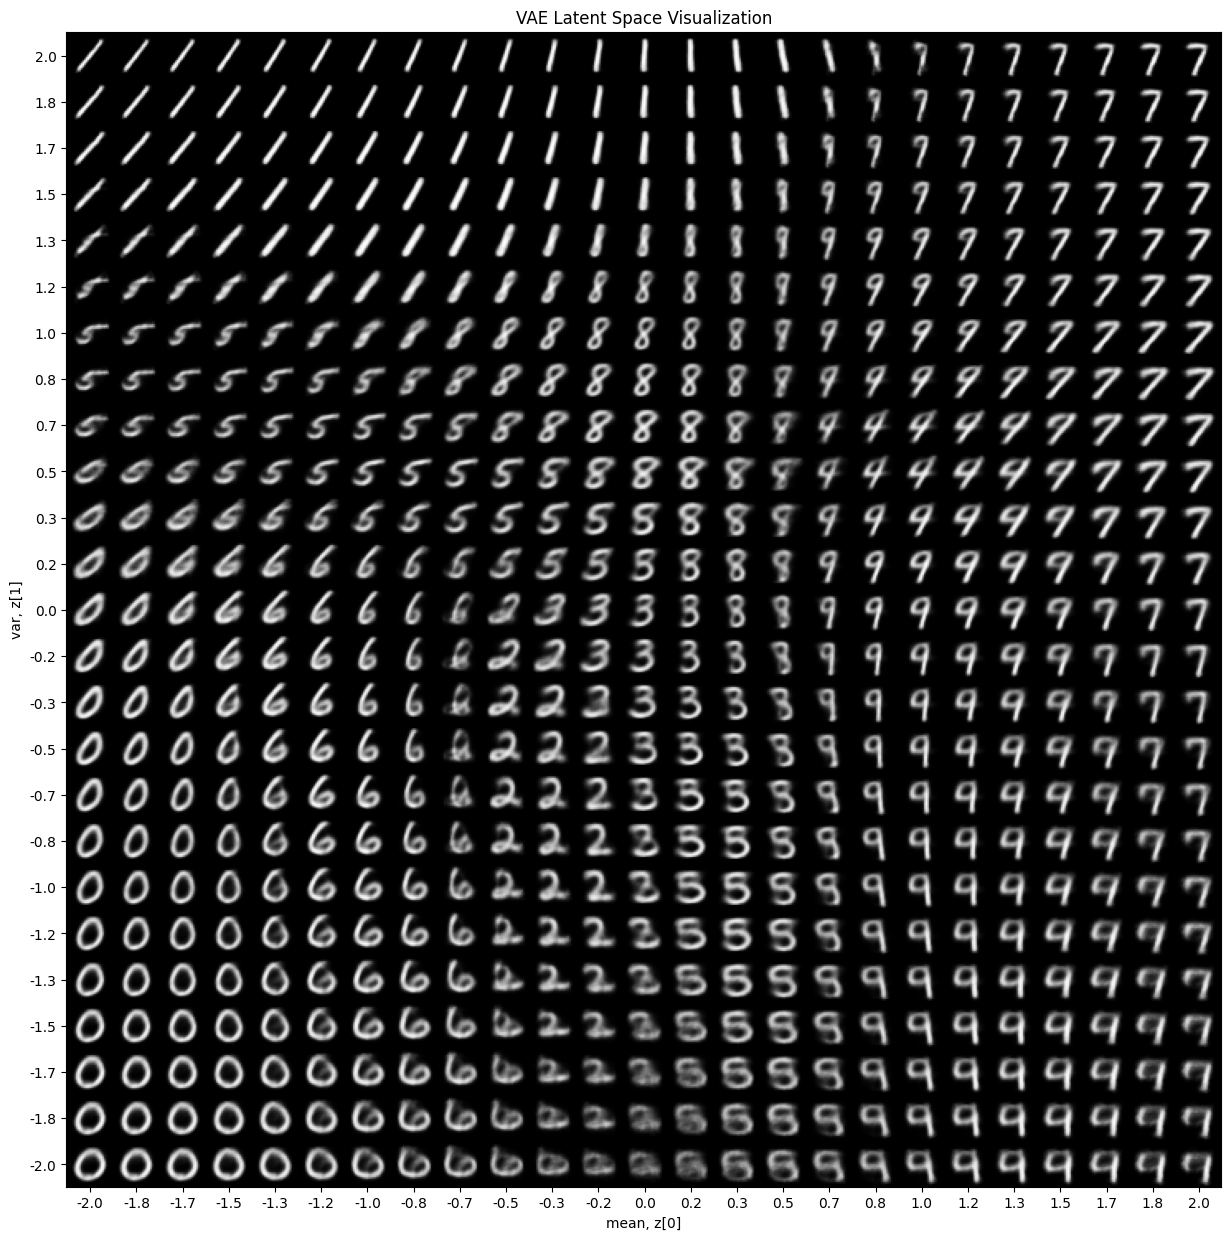

In [36]:
plot_latent_space(model, scale=2.0)